In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas
%matplotlib inline
from image_utils import show, resize_image, apply_clahe, crop_by_boxes
from text_detection import get_blob, non_max_suppression, get_net_output, get_boxes, draw_boxes, scale_boxes, enlarge_boxes

In [2]:
import math
import pytesseract
from pytesseract import Output
from PIL import Image

In [3]:
model_path = "frozen_east_text_detection.pb"
net = cv2.dnn.readNet(model_path)

In [13]:
def get_first_crops(impath, net, showInfo=False):
    size = 320
    scaleX = 150
    scaleY = 40
    img = cv2.imread(impath)
    if showInfo:
        show(img)
    # apply CLAHE
    cl = apply_clahe(img)
    # resize image and get blob (both for original and processed image)
    (frame_orig, rW, rH) = resize_image(img, (size, size))
    (frame_cl, _, _) = resize_image(cl, (size, size))
    blob_orig = get_blob(frame_orig)
    blob_cl = get_blob(frame_cl)

    # find boxes for original and processed image
    all_boxes = []
    for i, blob in enumerate([blob_orig, blob_cl]):
        (scores, geometry) = get_net_output(net, blob)   
        boxes = get_boxes(scores, geometry, minConfidence=0.6, overlapThresh=0) #0.7
        with_boxes = draw_boxes(frame_orig, boxes)
        bigger_boxes = enlarge_boxes(boxes, frame_orig.shape, scaleX, scaleY)
        res_boxes = scale_boxes(bigger_boxes, rW, rH)
        all_boxes.extend(res_boxes)
    with_b = draw_boxes(img, all_boxes, thickness=20)
    crops = crop_by_boxes(img, all_boxes)
    return crops

In [5]:
def check_proportion(imShape, boxShape, wSize, hSize):
    wRatio = boxShape[0] / imShape[1]
    hRatio = boxShape[1] / imShape[0]
    return (wRatio > wSize and hRatio > hSize) # and (wRatio < 1 and hRatio < 1)

def get_refined_crops(crops, showInfo=False):
    new_crops = []
    for img in crops:
        imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(4,4))
        cl1 = clahe.apply(imgray)
        imgray = cl1
        imgray = cv2.GaussianBlur(imgray, (9, 9), 0)
        ret,thresh = cv2.threshold(imgray,127,255,cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #RETR_CCOMP
        new_contours = []
        for i in range(len(contours)):
            if len(contours[i]) > 50:
                new_contours.append(contours[i])
        contours = new_contours

        empty = np.zeros_like(img)
        cv2.drawContours(empty, contours, -1, (0,255,0), 3)
        mask = np.ones_like(img) * 255
        boxes = []
        for contour in contours:
            if cv2.contourArea(contour) > 100:
                hull = cv2.convexHull(contour)
                r = random.random() * 255
                g = random.random() * 255
                b = random.random() * 255
                cv2.drawContours(mask, [hull], -1, (r,g,b), 5)
                x,y,w,h = cv2.boundingRect(contour)
                if w>h and check_proportion(img.shape, (w,h), 0.1, 0.1):
                    boxes.append((x,y,x+w,y+h))
        if showInfo:
            show(mask)
        new_crops = crop_by_boxes(img, boxes) 
    return new_crops

In [6]:
def filter_crops(crops, net):
    size = 320
    new_crops = []
    for img in crops:
        cl = apply_clahe(img)
        (frame_orig, rW, rH) = resize_image(img, (size, size))
        (frame_cl, _, _) = resize_image(cl, (size, size))
        blob_orig = get_blob(frame_orig)
        blob_cl = get_blob(frame_cl)
        all_boxes = []
        for i, blob in enumerate([blob_orig, blob_cl]):
            (scores, geometry) = get_net_output(net, blob)
            boxes = get_boxes(scores, geometry, minConfidence=0.6, overlapThresh=0) #0.7
            all_boxes.extend(boxes)
        if len(all_boxes) > 0:
            new_crops.append(img)
    return new_crops

In [7]:
def ImageDPI(img):
    img.save('ocr.png', dpi=(1200, 1200))
    image = cv2.imread('ocr.png')
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    return image

def preprocess(img):
    image = ImageDPI(img)
    threshold = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    threshold = cv2.bilateralFilter(threshold,9,75,75)
    _,threshold = cv2.threshold(threshold,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    listBlack = []
    listWhite = []
    for i in threshold:
        for j in i:
            if j > 0:
                listWhite.append(j)
            else:
                listBlack.append(j)

    if len(listBlack) > len(listWhite):
        _,threshold = cv2.threshold(threshold,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return threshold

def tesser(img):
    custom_config = r'--oem 3 --psm 11 -c tessedit_char_blacklist==:;\'—-*<>^%#@\"$!+”“|№.,«»„`©{}()&’?_‘[]'
    text = pytesseract.image_to_string(img, lang = "rus", config=custom_config)
    return text

def filterStr(text):
    blackList = "=:;'—-*<>^%#@\"$!+”“|№.,«»„`©{}()&’?_‘[]"
    for x in blackList:
        text = text.replace(x,'')
    text = [s.lower().strip() for s in text.splitlines() if len(s)>3 or s.isdigit()] 
    text = ' '.join(text).split(' ')
    text = [s for s in text if len(s) > 2]
    return text
        
def distanceLevenshtein(a, b):
    n, m = len(a), len(b)
    if n > m:
        a, b = b, a
        n, m = m, n
    current_row = range(n + 1)
    for i in range(1, m + 1):
        previous_row, current_row = current_row, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete, change = previous_row[j] + 1, current_row[j - 1] + 1, previous_row[j - 1]
            if a[j - 1] != b[i - 1]:
                change += 1
            current_row[j] = min(add, delete, change)
    return current_row[n]

# для одного кропа
def minAnswer(textList,image_dir):
    truth = a_dict[image_dir]
    minDist = 100
    street=""
    for x in textList:
        dist = distanceLevenshtein(truth,x)
        if(dist < minDist):
            minDist = dist
            street = x
    return street, minDist

def ResultAlgorithm(image_dir, image_dirUp):
    resultList = []
    imgList = []
    space = ' '
    images = os.listdir(image_dirUp+'/'+image_dir)
    for x in images:
        strl = image_dirUp+'/'+image_dir+'/'+x
        # запускаем тессеракт
        img,text = tesser(preproccessing(Image.open(strl)))
        textList = filterStr(text)
        imgList.append(img)
        resultList.append(space.join(textList))
    return resultList, imgList

In [14]:
def get_answers(impath, net, true_answer, showInfo=False):
    # get crops using EAST text detector
    crops = get_first_crops(impath, net, showInfo)
    
    if showInfo:
        print("First step crops: ", len(crops))
        for c in crops:
            show(c)
    
    # get better crops using contours
    crops2 = get_refined_crops(crops, showInfo)
    # filter crops using EAST text detector (again)
    crops3 = filter_crops(crops2, net)
    if showInfo:
        print("Second step crops: ", len(crops3))
        for c in crops3:
            show(c)
            
    # get possible answers using Tesseract
    res = []
    for img in crops3:
        img2 = preprocess(Image.fromarray(img))
        text = tesser(img2)
        text = filterStr(text)
        res.append(text)
    # calculate error with Levenstein distance
    # opt.1 (don't join words and compare them separately with correct answer)
    errors1 = []
    err1 = 100
    for answer in res:
        for word in answer:
            d = distanceLevenshtein(true_answer, word)
            l = max(len(true_answer), len(word))
            d = (d / l) * 100
            errors1.append(d)
    if len(errors1)>0:
        err1 = min(errors1)
    
    # opt.2 (join words with space and compare the whole string with correct answer)
    errors2 = []
    err2 = 100
    res2 = [' '.join(strs) for strs in res]
    for words in res2:
        d = distanceLevenshtein(true_answer, words)
        l = max(len(true_answer), len(words))
        d = (d / l) * 100
        errors2.append(d)
    if len(errors2)>0:
        err2 = min(errors2)
    return res, err1, err2

In [32]:
def get_img_text(df, imname):
    return df.loc[df["name"]==imname]["text"].item()

In [58]:
image_texts = pandas.read_csv("../../../data/dictionary_full.csv", sep=";")
imgs_path = "../../../data/addresses_full1"
images = os.listdir(imgs_path)
images.sort()

In [59]:
# cycle for all dataset
err1_sum = 0
err2_sum = 0
not_wrong = 0
total_len = len(images)
for imname in images:
    impath = imgs_path+'/'+ imname
    res, err1, err2 = get_answers(impath, net, get_img_text(image_texts, imname), showInfo=False)    
    err1_sum += err1
    err2_sum += err2
    
    if err1<100 or err2<100:
        not_wrong += 1
    
    print(imname)
    print(res)
    print(err1, err2)
    
err1_sum /= total_len
err2_sum /= total_len
print("Total error:")
print(err1_sum, err2_sum)

002.JPG
[[], ['чата', 'сзенекль', 'сани', 'ччзнириниях']]
80.0 90.0
007.JPG
[['92/2', 'краснодарская']]
50.0 30.76923076923077
009.JPG
[['переулок', 'нефтекачка']]
54.54545454545454 13.636363636363635
013.JPG
[['володарского', '197'], ['володарского', '197'], ['володарского', '197/']]
36.84210526315789 21.052631578947366
014.JPG
[['овад'], ['портовая', '221'], ['221'], [], []]
46.666666666666664 20.0
015.JPG
[['544', 'мята', 'еощаеяе', 'чем', 'фейс', '427', '112725', '2122', '177', 'эха', '254', 'мых', 'зиг', 'озие', 'щас'], ['747', '277', 'ети', '252', 'кссы', 'зруче', 'жерм', 'ыиач', '7115', 'очень', '2774', '354', 'маем', '2кдилы', 'ламы', 'выщ', 'щим', 'иены', '714', 'мдм', 'ривис', '1572', 'река', 'кмета', '295', '239', '577', '247', '972', 'оды', 'горекх', 'мия', 'имовича', 'мых', 'пам', 'метр', '257', 'сем', 'сие', 'тра', 'ных', 'мечет', 'мех', 'мезяь', 'даь', '357', 'зыриьтя', '9447', '2чы9/', 'кеть', 'очень', 'нак', 'сари', '347', '529', 'ааа', 'аит', 'асорах', 'нтель', '474',

KeyboardInterrupt: 

../../../data/1data/009.JPG


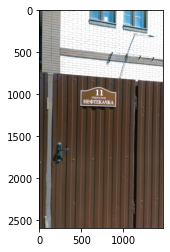

First step crops:  1


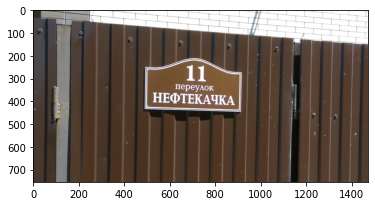

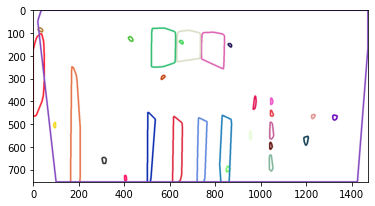

Second step crops:  1


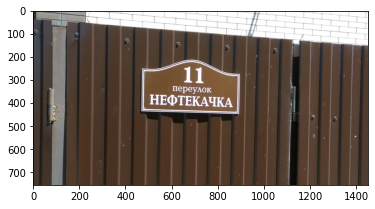

[['переулок', 'нефтекачка']]
54.54545454545454 13.636363636363635


In [23]:
# test for one image
imname=images[15]
impath = imgs_path+'/'+ imname
print(impath)
res, err1, err2 = get_answers(impath, net, get_img_text(image_texts, imname), showInfo=True)
print(res)
print(err1, err2)